## Import packages and load data

In [12]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import gensim.downloader
import numpy as np
import string
import scipy.spatial
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn import metrics
import pickle
from datetime import datetime
from utils import * # import utilities
data = pd.read_csv('../input/netflix_titles.csv')

## Preprocess the text 
listed_in $\rightarrow$genre, description + title $\rightarrow$ words

In [24]:
data['words'] = process_text2(data['title'] + ' ' + data['description'])
data['genre'] = process_text2(data['listed_in'])

In [25]:
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,words,genre
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,"[future, elite, inhabit, island, paradise, far...","[international, tv, show, tv, drama, tv, fantasy]"
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,"[devastating, earthquake, hit, mexico, city, t...","[drama, international, movie]"
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...","[army, recruit, found, dead, fellow, soldier, ...","[horror, movie, international, movie]"
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...","[postapocalyptic, world, robot, hide, fear, da...","[action, adventure, independent, movie, fantasy]"
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,"[brilliant, group, student, become, expert, in...",[drama]


Looking into the genre, we can see that there are many repeated words in genre. However, 2 "tv" will not make great difference to the nature of the entry than 1 "tv". Therefore, words in genre should be distinct.

In [4]:
# Remove repeated words in genre
data['genre'] = data['genre'].apply(lambda row: list(set(row)))
pd.DataFrame(data['genre']).head()

,genre
0,"[drama, tv, show, fantasy, international]"
1,"[drama, international, movie]"
2,"[horror, international, movie]"
3,"[action, movie, adventure, independent, fantasy]"
4,[drama]


## Prepare dataset from gensim and add some more sentence
1. Download gensim dataset *text8* from http://mattmahoney.net/dc/text8.zip, unzip and place it under the 
2. Add some more sentences from data['words'] to the end of "text8"

In [49]:
# Prepare the "more sentences"
more_sentences = []
words_set = set() # for checking only
for i in range(len(data['words'])):
    tmp = data['words'].iloc[i]
    more_sentences.append(tmp)
    words_set.update(tmp)
str_total = ''
for lst in more_sentences:
    str_add = ' '.join(lst)
    str_total += str_add
print("There are {} more sentences, {} distinct words in total.".format(len(more_sentences),len(words_set)))


There are 7787 more sentences, 18431 distinct words in total.


## If text8 is already modified, do Not run the cell below.

In [ ]:
# Write to text8
file = '../input/text8/text8'
with open(file, 'r',encoding='utf-8') as f:
    contents = f.readline().split()
print("There are {} words ")

with open(file, 'a+',encoding='utf-8') as f:
    f.write(str_total)

## Build the word2vec model

In [21]:
# sentences = word2vec.Text8Corpus('../input/text8/text8')
# # training
# model = word2vec.Word2Vec(vector_size=100, min_count=1)#, window=5, min_count=1, workers=4)
# model.build_vocab(sentences)
# model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)
# model.save('../model/text8-test.model')
model = word2vec.Word2Vec.load("../model/text8-test.model")
embeddings = model.wv

2021-04-11 01:29:58,374 : INFO : loading Word2Vec object from ../model/text8-test.model
2021-04-11 01:29:58,451 : INFO : loading wv recursively from ../model/text8-test.model.wv.* with mmap=None
2021-04-11 01:29:58,452 : INFO : setting ignored attribute cum_table to None
2021-04-11 01:29:58,958 : INFO : Word2Vec lifecycle event {'fname': '../model/text8-test.model', 'datetime': '2021-04-11T01:29:58.958986', 'gensim': '4.0.0', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.18362-SP0', 'event': 'loaded'}


## Calculate the embeddings for words

In [27]:
# Calculate
embeddings = model.wv
embs_words, unknown_words = cal_emb(data['words'])
print(unknown_words[:20])
# print("Percentage of unknown words: {}%".format(100*len(unknown_words) / sum([len(sentence) for sentence in sentences])))

2021-04-11 01:40:15,557 : INFO : loading Word2Vec object from ../model/text8.model
2021-04-11 01:40:15,619 : INFO : loading wv recursively from ../model/text8.model.wv.* with mmap=None
2021-04-11 01:40:15,624 : INFO : loading vectors from ../model/text8.model.wv.vectors.npy with mmap=None
2021-04-11 01:40:15,659 : INFO : loading syn1neg from ../model/text8.model.syn1neg.npy with mmap=None
2021-04-11 01:40:15,704 : INFO : setting ignored attribute cum_table to None
2021-04-11 01:40:17,606 : INFO : Word2Vec lifecycle event {'fname': '../model/text8.model', 'datetime': '2021-04-11T01:40:17.606093', 'gensim': '4.0.0', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.18362-SP0', 'event': 'loaded'}


finish the 0 rows
finish the 100 rows
finish the 200 rows
finish the 300 rows
finish the 400 rows
finish the 500 rows
finish the 600 rows
finish the 700 rows
finish the 800 rows
finish the 900 rows
finish the 1000 rows
finish the 1100 rows
finish the 1200 rows
finish the 1300 rows
finish the 1400 rows
finish the 1500 rows
finish the 1600 rows
finish the 1700 rows
finish the 1800 rows
finish the 1900 rows
finish the 2000 rows
finish the 2100 rows
finish the 2200 rows
finish the 2300 rows
finish the 2400 rows
finish the 2500 rows
finish the 2600 rows
finish the 2700 rows
finish the 2800 rows
finish the 2900 rows
finish the 3000 rows
finish the 3100 rows
finish the 3200 rows
finish the 3300 rows
finish the 3400 rows
finish the 3500 rows
finish the 3600 rows
finish the 3700 rows
finish the 3800 rows
finish the 3900 rows
finish the 4000 rows
finish the 4100 rows
finish the 4200 rows
finish the 4300 rows
finish the 4400 rows
finish the 4500 rows
finish the 4600 rows
finish the 4700 rows
fini

We can see that unknown words are some uncommon words. Plus the pertentage of unknown words is not high. Therefore, the performance will not be affected much.

## Process other features
**country**\
Before: "Norway, Iceland, United States"\
After: ["norway", "iceland", "united states"]\

**rating**\
The ratings are groupped into 3 categories, "M" for mature, "G" for general, "Y" for young\
Before: "TV-Y","TY-G", etc.\
After: one of "Y", "G", "M"\

**cast**\
Select the first 3 and store in a list\
Before: "Samuel L. Jackson, John Heard, Kelly Rowan, Clifton Collins Jr., Tony Plana"\
After: ["Samuel L. Jackson", "John Heard","Kelly Rowan"]




In [28]:
# Process rating and cast
mature = ['TV-MA','R','PG-13','TV-14','TV-PG','PG','NC-17']
general = ['NR',np.nan,"G","UR",'TV-G']
young = ['TV-Y','TV-Y7','TV-Y7-FV']
mapping = {}
# mapping = {1:"Y",2:"G",3:"M"}
for item in young:
    mapping[item] = "Y"
for item in general:
    mapping[item] = "G"
for item in mature:
    mapping[item] = "M"
data['rating'] = data['rating'].apply(lambda item: mapping[item])


data['cast'] = data['cast'].apply(first_3)

In [29]:
data[['cast','rating']]

,cast,rating
0,"[joão miguel, bianca comparato, michel gomes]",M
1,"[demián bichir, héctor bonilla, oscar serrano]",M
2,"[tedd chan, stella chung, henley hii]",M
3,"[elijah wood, john c. reilly, jennifer connelly]",M
4,"[jim sturgess, kevin spacey, kate bosworth]",M
...,...,...
7782,"[imad creidi, antoinette turk, elias gergi]",M
7783,"[vicky kaushal, sarah-jane dias, raaghav chanana]",M
7784,[nasty c],M
7785,"[adriano zumbo, rachel khoo]",M


[3247, 987, 704, 397, 337, 281, 211, 210, 175, 151, 142, 136, 110, 108, 101, 88, 87, 85, 82, 79, 76, 76, 74, 65, 50, 43, 41, 40, 39, 37, 32, 31, 31, 28, 27, 26, 26, 25, 25, 24, 24, 19, 16, 13, 11, 10, 10, 10, 9, 9, 9, 9, 8, 7, 6, 6, 5, 5, 5, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


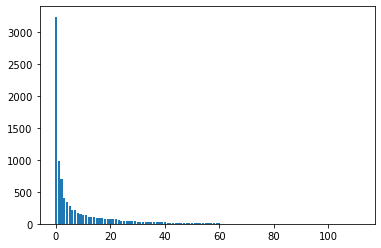

In [30]:
# Process country
data['country'] = data['country'].apply(split_comma)   
country_lst = []
from collections import Counter
for country in data['country']:
    country_lst += country
country_summary = dict(Counter(country_lst))
country_summary = dict(sorted(country_summary.items(), key = lambda kv:(kv[1], kv[0]),reverse=True))
tmp = list(country_summary.values())
from matplotlib import pyplot as plt
plt.bar(range(len(tmp)),tmp)
print(tmp)

We can see that some countries do not frequently appear. Therefore, we should not waste too many features on these countries.\
1. Select countries appear more than 100 times
2. Change other countries and missing entries into "other"

In [31]:
selected_country = dict([kv for kv in country_summary.items() if kv[1] >= 100])
selected_country_names = selected_country.keys()
print("There are {} countries selected.".format(len(selected_country)))
print("Country selected are: ",list(selected_country_names))

There are 15 countries selected.
Country selected are:  ['united states', 'india', 'united kingdom', 'canada', 'france', 'japan', 'spain', 'south korea', 'germany', 'mexico', 'australia', 'china', 'egypt', 'turkey', 'hong kong']


In [32]:
def change_country_name(lst):
    for i in range(len(lst)):
        if lst[i] not in selected_country_names:
            lst[i] = 'other'
    if len(lst) <= 0:
        lst = ['other']
    return list(set(lst))

# data['country'] = data['country'].apply(change_country_name)
data['country'] = data['country'].apply(lambda row: list(set(row)))
data['country'].head(20)

0                             [brazil]
1                             [mexico]
2                          [singapore]
3                      [united states]
4                      [united states]
5                             [turkey]
6                              [egypt]
7                      [united states]
8                              [india]
9                              [india]
10                     [united states]
11             [poland, united states]
12                            [mexico]
13                          [thailand]
14                     [united states]
15                           [nigeria]
16                                  []
17    [united states, iceland, norway]
18                             [india]
19                    [united kingdom]
Name: country, dtype: object

## Generate feature vectors
1. Convert categorical features into one hot representation
2. Concatenate categorical features with word embeddings

In [33]:
# Convert categorical features into one hot representation ('genre','country','rating','type')
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)
data2 = data
data2 = data[['type', 'title','country', 'rating', 'words', 'genre']]
data2 = data2.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(data.pop('genre')),
                index=data.index,
                columns=mlb.classes_))
data2 = data2.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(data2.pop('country')),
                index=data.index,
                columns=mlb.classes_))

data2 = data2.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(data2.pop('rating')),
                index=data.index,
                columns=mlb.classes_))

data2['type'] = data2['type'].apply(lambda row: 1 if row.lower().find('movie')!=-1 else 0)
data2.columns

Index(['type', 'title', 'words', 'genre', 'action', 'adventure', 'anime',
       'british', 'child', 'classic',
       ...
       'united states,', 'uruguay', 'vatican city', 'venezuela', 'vietnam',
       'west germany', 'zimbabwe', 'G', 'M', 'Y'],
      dtype='object', length=157)

In [34]:
data2.head()

,type,title,words,genre,action,adventure,anime,british,child,classic,...,"united states,",uruguay,vatican city,venezuela,vietnam,west germany,zimbabwe,G,M,Y
0,0,3%,"[future, elite, inhabit, island, paradise, far...","[international, tv, show, tv, drama, tv, fantasy]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,7:19,"[devastating, earthquake, hit, mexico, city, t...","[drama, international, movie]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,23:59,"[army, recruit, found, dead, fellow, soldier, ...","[horror, movie, international, movie]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,9,"[postapocalyptic, world, robot, hide, fear, da...","[action, adventure, independent, movie, fantasy]",1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,21,"[brilliant, group, student, become, expert, in...",[drama],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [35]:
# Convert categorical features with to nparray
mat = np.array(data2.drop(columns=['title','words','genre'])).astype(np.int32)
print("There are {} categorical features.".format(mat.shape[1]))


There are 154 categorical features.


In [36]:
vectors  = np.concatenate((mat,embs_words),axis = 1)
print(vectors.shape)
np.save('../data/vectors-show.npy',vectors)
vectors = np.load('../data/vectors-show.npy',allow_pickle=True)

(7787, 254)


## Calculate the similarity

In [38]:
norm_vectors = scale(vectors)
cosine_sim = 1 - scipy.spatial.distance.cdist(norm_vectors,norm_vectors, metric='cosine')
euclidean_sim = scipy.spatial.distance.cdist(norm_vectors,norm_vectors, metric='euclidean')
np.savez('../data/dist-show.npz', cosine_sim, euclidean_sim)  


## Recommend
**Input**\
title of the movie, dataframe of the original data, name of the distance file(in case there are many distance files, generated from different preprocessing methods)\
**output**\
2 dataframes: one without input and one with

In [ ]:
def recommend(title,data,dist_name, metric='cosine'):
    # load the distance
    files = np.load('../data/'+dist_name)
    cosine_sim = files['arr_0']
    euclidean_sim = files['arr_1']
    indices = pd.Series(data.index, index = data['title'].str.lower()).drop_duplicates()
    del files # save memory
    idx = indices[title.lower()]
    if metric =='cosine':
        sim_vec = cosine_sim[idx]
        # Get the pairwsie similarity scores of all movies with that movie
    elif metric == 'euclidean':
        sim_vec = euclidean_sim[idx]
        
    sim_scores = list(enumerate(sim_vec))        
    # Sort the movies based on the similarity scores
    sorted_sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    res = sorted_sim_scores[:11]
    res = [item for item in res if item[0]!=idx]

    # Get the movie indices
    res_indices = [item[0] for item in res]
    res_score = [item[1] for item in res]   
    
    final_data = data.iloc[res_indices]
    final_data.insert(0,'score',res_score)
    
    with_input_indices = [idx]+res_indices
    with_input_score = [1]+res_score 
    
    with_input_data = data.iloc[with_input_indices]
    with_input_data.insert(0,'score',with_input_score)
    col_lst = [ 'score', 'type', 'title',  'country', 'rating',
       'listed_in', 'description']
    return final_data[col_lst], with_input_data[col_lst]

In [ ]:
title = 'The Visit'
metric='euclidean'
final_data,with_input_data = recommend(title, data,dist_name="dist-show.npz")

In [ ]:
final_data

In [45]:
def search_recommend(sentence, data, metric='cosine',w_genre=0.5):
    file = np.load("../data/emb_w_g.npz",allow_pickle=True)
    embs_words, embs_genre = file.values()
    # embs = embs_words * (1 - w_genre) + embs_genre * w_genre
    embs = embs_words
    del file
    indices = pd.Series(data.index, index = data['title'].str.lower()).drop_duplicates()
    embs_sentence, unknown_sentence = cal_emb(process_text2(pd.Series(sentence)))
    if metric =='cosine':
        sim_vec = cosine_sim_words = metrics.pairwise.cosine_similarity(embs_sentence.reshape(1, -1), embs)

        # Get the pairwsie similarity scores of all movies with that movie
    elif metric == 'euclidean':
        sim_vec = scipy.spatial.distance.cdist(embs_sentence.reshape(1, -1), embs, metric='euclidean')
        sim_vec = 1 / np.abs(sim_vec)
    
    sim_scores = list(enumerate(sim_vec.reshape(-1,1)))
    
    sorted_sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    res = sorted_sim_scores[:10]

    # Get the movie indices
    res_indices = [item[0] for item in res]
    res_score = [item[1] for item in res]   
    
    final_data = data.iloc[res_indices]
    final_data.insert(0,'score',res_score)
    
    col_lst = [ 'score',  'type', 'title',  'country', 'rating',
       'listed_in', 'description']
    return final_data[col_lst]

In [46]:
search_recommend("hello my friend! Miss you so much",data)

2021-04-11 01:45:02,128 : INFO : loading Word2Vec object from ../model/text8.model
2021-04-11 01:45:02,182 : INFO : loading wv recursively from ../model/text8.model.wv.* with mmap=None
2021-04-11 01:45:02,187 : INFO : loading vectors from ../model/text8.model.wv.vectors.npy with mmap=None
2021-04-11 01:45:02,227 : INFO : loading syn1neg from ../model/text8.model.syn1neg.npy with mmap=None
2021-04-11 01:45:02,263 : INFO : setting ignored attribute cum_table to None
2021-04-11 01:45:04,113 : INFO : Word2Vec lifecycle event {'fname': '../model/text8.model', 'datetime': '2021-04-11T01:45:04.113668', 'gensim': '4.0.0', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.18362-SP0', 'event': 'loaded'}


finish the 0 rows
There are 0 unknown words.


,score,type,title,country,rating,listed_in,description
3317,[0.8298872811427987],Movie,Katha,[india],M,"Comedies, Dramas, Independent Movies","Secretly in love with his neighbor, a mild-man..."
3656,[0.825407415644228],TV Show,Little Baby Bum: Nursery Rhyme Friends,[united kingdom],Y,"British TV Shows, Kids' TV","Twinkle, Mia, Jacus and the rest of the Nurser..."
4330,[0.7998429522148135],Movie,My Little Pony Equestria Girls: Forgotten Frie...,"[canada, united states]",Y,Children & Family Movies,School yearbook editor Sunset Shimmer has sudd...
2288,[0.7947912627660766],TV Show,Friends,[united states],M,"Classic & Cult TV, TV Comedies",This hit sitcom follows the merry misadventure...
7502,[0.7726338854886157],Movie,We Are Your Friends,"[united kingdom, france, united states]",M,"Dramas, Independent Movies, Music & Musicals",An ambitious young DJ who knows how to work a ...
3522,[0.7681831456462076],Movie,Lagos Real Fake Life,[],M,"Comedies, International Movies",Two mooching friends vie for the attention of ...
3583,[0.7681645749209132],TV Show,LEGO Friends: The Power of Friendship,[denmark],Y,Kids' TV,Five best friends face adventures side by side...
3061,[0.7673768534104126],TV Show,Is It Wrong to Try to Pick Up Girls in a Dungeon?,[japan],M,"Anime Series, International TV Shows","Lovable goof Bell Cranel wants an adventure, a..."
2475,[0.7639739549004583],Movie,Good and Prosperous,[egypt],M,"Comedies, International Movies",As two jobless brothers search aimlessly for c...
5420,[0.7630014996907921],Movie,Say When,[united states],M,"Comedies, Dramas, Independent Movies","Desperately clinging to her youth, 28-year-old..."
